#Fine Tuning BERT Model on CoLA Dataset

In [ ]:
import tensorflow as tf
# get device name

device_name =  tf.test.gpu_device_name()
if device_name =='/device:GPU:0':
  print("Found GPU at : {}".format(device_name))
else:
  raise SystemError("GPU not found")

Found GPU at : /device:GPU:0


In [ ]:
import torch

# if there is GPU is available
if torch.cuda.is_available():
  #tell Pytorch to use the GPU
  device = torch.device("cuda")
  print("There is {torch.cuda.device_count()} GPU(s) avaliable")
  print(f"We will use the GPU : {torch.cuda.get_device_name(0)}")
else :
  print("No GPU avaliable, We are useing CPU")
  device = torch.device("cpu")

There is {torch.cuda.device_count()} GPU(s) avaliable
We will use the GPU : Tesla K80


## 1.2 Install HuggingFace Library

In [ ]:
#installing transfermers with no out strings
!pip install transformers --quiet

## 2.1 Downloading Dataset

In [ ]:
!pip install wget --quiet

In [ ]:
#CoLA : https://nyu-mll.github.io/CoLA/
import wget
import os
print("Downloading dataset")
url = "https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"

#Download dataset if the file does not exist
if not os.path.exists("./cola_public_1.1.zip"):
  wget.download(url,"./cola_public_1.1.zip")
  !unzip ./cola_public_1.1.zip

## Loading Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print(f"Number of training Sentence {df.shape[0]}")
df.sample(10)

Number of training Sentence 8551


,sentence_source,label,label_notes,sentence
2389,l-93,1,NaN,Angela characterized Shelly as a lifesaver.
5048,ks08,1,NaN,They're not finding it a stress being in the s...
3133,l-93,0,*,Paul exhaled on Mary.
5955,c_13,0,*,I ordered if John drink his beer.
625,bc01,1,NaN,Press the stamp against the pad completely.
3542,ks08,0,*,They can very.
6915,m_02,1,NaN,This arch is supporting the weight of the tower.
2908,l-93,1,NaN,That new handle detaches easily.
5857,c_13,1,NaN,The Brazilians pumped the oil across the river.
4191,ks08,1,NaN,It is a wooden desk.


We have labales 0 or 1 label in dataset.We need only two columns sentence and lables

In [ ]:
df[['sentence','label']].sample(5)

,sentence,label
571,The sponge soaked up the water.,1
6393,John talked to every woman who came up to him.,1
608,What the force of the wind did to the window w...,1
4745,What can the child read?,1
4426,Was the child in the school?,1


In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix,classification_report
%matplotlib inline
%config InlineBacked.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


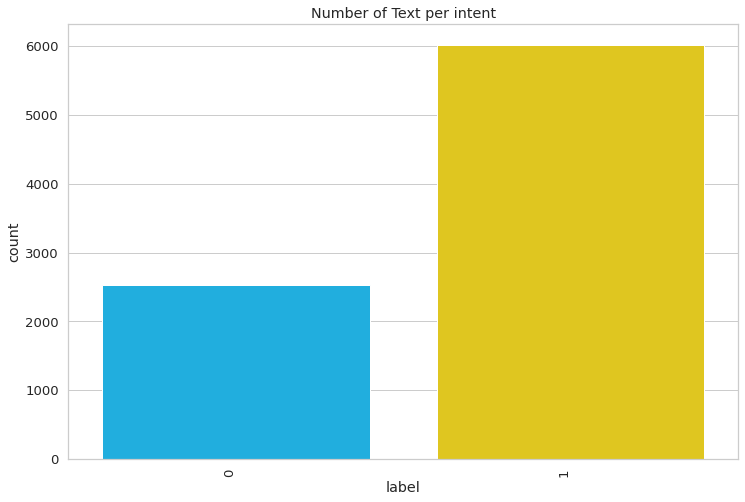

In [ ]:
chart  = sns.countplot(df.label,palette=HAPPY_COLORS_PALETTE)
plt.title("Number of Text per intent")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90,horizontalalignment='right');
plt.show()

In [ ]:
print(f"Total Length of Dataset {len(df)}")

Total Length of Dataset 8551


In [ ]:
sentences = df.sentence.values
labels   = df.label.values

## 3. Tokenization and input formatting

## 3.1 Tokenization

In [ ]:
from transformers import BertTokenizer
#loading the BERT Tokenizer
print("Loading BERT Tokenizer")
tokenizer =  BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True )

Loading BERT Tokenizer


In [ ]:
print(f"Orginal        : {sentences[0]}")

print(f"Tokenized      : {tokenizer.tokenize(sentences[0])}")

print(f"Tokenize Id's  : {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0]))}")

Orginal        : Our friends won't buy this analysis, let alone the next one we propose.
Tokenized      : ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Tokenize Id's  : [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


## 3.3 Adding Special Tokens[CLS] and [SEP]

In [ ]:
# getting max length of sentence
max_len = 0
for sent in sentences :
  # tokenize and adding [CLS],[SEP] tokens
  input_ids = tokenizer.encode(sent,add_special_tokens =True)
  #update the maxium sentence length
  max_len = max(max_len,len(input_ids))
print(f"Max sentence length is {max_len}")

Max sentence length is 47


Now We are ready to apply real tokenization
we are going to use tokenizer.encode_plus  which combine multiple steps
1. split the sentence into tokens
2. add the sepcial tokens [CLS] and [SEP]
3. map the tokens to their IDs
4. PAD or Truncate all sentence to sentence same length
5. create attention masks

In [ ]:
input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict =tokenizer.encode_plus(
      sent,
      add_special_tokens =True,
      max_length =64,
      truncation=True,
      padding='max_length',
      return_attention_mask =True,
      return_tensors ='pt'
  )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

#converting all the list into tensors
input_ids = torch.cat(input_ids,dim=0)
attention_masks = torch.cat(attention_masks,dim=0)
labels = torch.as_tensor(labels)

#printing sentence 0 token id and attention mask
print(f"Orignal Sentence  : {sentences[0]}")
print(f"Sentence ids      : {input_ids[0]}")
print(f"Sentence label    : {labels[0]}")

Orignal Sentence  : Our friends won't buy this analysis, let alone the next one we propose.
Sentence ids      : tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Sentence label    : 1


## 3.4 Training and Validation split

In [ ]:
from torch.utils.data import TensorDataset,random_split
# combining training inputs
dataset = TensorDataset(input_ids,attention_masks,labels)

#creating a 90-10 training and validation set
train_size = int(0.9*len(dataset))
val_size   = len(dataset)- train_size

#Dividing the dataset by randomly selecting samples
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print(f"Training Sample   : {train_size}")
print(f"Validation Sample : {val_size}")

Training Sample   : 7695
Validation Sample : 856


We also create dataloader iterator

In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler= RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler =SequentialSampler(val_dataset),
    batch_size =batch_size
)

## 4. Train Classification Model

In [ ]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

#Laoding BertForSequenceClassification, pretrained BERT Model with a single
#linear Classification layer on Top

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions =False,
    output_hidden_states =False,
)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())

print(f"The BERT Model has {len(params)} different named parameters \n ")

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT Model has 201 different named parameters 
 
==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2 Optimizer and Learning Rate Scheduler

In [ ]:
#recommanded by BERT model
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps =0,
                                            num_training_steps = total_steps)


## 4.3 Defining Helper Functions

In [ ]:
import numpy as np
# function to calculate the accuracy of our predictions vs Labels
def flat_accuracy(preds,labels):
  pred_flat   = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat==labels_flat)/len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
  "Take time in seconds and return a string in hh:mm:ss"
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## 4.4 model Training

In [ ]:
import random
import numpy as np

seed_val =42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0,epochs):
  #==================================#
  #           Training               #
  #==================================#

  print("")
  print(f"==============Epochs : {epoch_i+1}/{epochs}============")
  print("Training...")
  t0 = time.time()
  total_train_loss = 0
  model.train()
  # for each batch of training data

  for step,batch in enumerate(train_dataloader):

    #progress update every 40 batches
    if step%40==0 and not step == 0:
      #calculate elapsed time in minute 
      elapsed = format_time(time.time()-t0)
      #Report Progress
      print(f"Batch {step} of {len(train_dataloader)}. Elapsed : {elapsed}")

    #unpack this training Batch form our dataloader
    #batch contains three pytorch tensors:
    # [0]: input_ids
    # [1]: attention masks
    # [2]: labels
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device)

    model.zero_grad()

    result = model(b_input_ids,
                   token_type_ids=None,
                   attention_mask=b_input_mask,
                   labels =b_labels,
                   return_dict=True)
    loss = result.loss
    logits = result.logits

    total_train_loss +=loss.item()

    loss.backward()
    
    #Clip the norm of gradients to 1.0
    #This is help to prevent the "exploding gradients" problem
    torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

    optimizer.step()
    scheduler.step()
  #Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss/len(train_dataloader)
  training_time  =  format_time(time.time()-t0)
  
  print("")
  print("  Average training loss: {0:.4f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  #==================================#
  #           Validation             #
  #==================================#
  print("")
  print("Runing Validation...")
  t0=time.time()

  #putting model in evaluation mode-- the dropout layers behave differentlu 
  model.eval()
  # Tracking Variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  #Evaluate data for one epoch
  for batch in validation_dataloader:
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device)

    #Since we don't backpropgration
    with torch.no_grad():
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels,
                     return_dict =True
                     )
    # get the loss and logits.The "Logits" are activation function after output value
    #Softmax
    loss   = result.loss
    logits = result.logits

    #Accumulate the valiationloss
    total_eval_loss +=loss.item()

    #Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()
    #Accumulate it over all batchs
    total_eval_accuracy +=flat_accuracy(logits,label_ids)
  
  #Final Accuracy
  avg_val_accuracy = total_eval_accuracy/len(validation_dataloader)
  print(f"Accuracy : {avg_val_accuracy:.4f}")

  #Calculate the AVG Loss
  avg_val_loss = total_eval_loss/len(validation_dataloader)

  #Measuring Time
  validation_time = format_time(time.time()-t0)
  print("Validation loss {:.4f}".format(avg_val_loss))
  print("Validation time {}".format(validation_time))

  #Every Eoch entry
  training_stats.append(
      {
       'epoch':epoch_i+1,
       'Training Loss': avg_train_loss,
       'Valid. Loss' : avg_val_loss,
       'Valid. Accur' : avg_val_accuracy,
       'Training Time':training_time,
       'Validation Time':validation_time
      }
  )
  print("")
  print("Training Completed ! ") 
  print(f"Total training took {format_time(time.time()-total_t0)} ")  


==============Epochs : 1/4============
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Batch 40 of 241. Elapsed : 0:00:29
Batch 80 of 241. Elapsed : 0:00:57
Batch 120 of 241. Elapsed : 0:01:26
Batch 160 of 241. Elapsed : 0:01:54
Batch 200 of 241. Elapsed : 0:02:23
Batch 240 of 241. Elapsed : 0:02:51

  Average training loss: 0.5080
  Training epcoh took: 0:02:51

Runing Validation...
Accuracy : 0.8241
Validation loss 0.4126
Validation time 0:00:06

Training Completed ! 
Total training took 0:02:58 

==============Epochs : 2/4============
Training...
Batch 40 of 241. Elapsed : 0:00:28
Batch 80 of 241. Elapsed : 0:00:57
Batch 120 of 241. Elapsed : 0:01:25
Batch 160 of 241. Elapsed : 0:01:54
Batch 200 of 241. Elapsed : 0:02:22
Batch 240 of 241. Elapsed : 0:02:51

  Average training loss: 0.3165
  Training epcoh took: 0:02:51

Runing Validation...
Accuracy : 0.8329
Validation loss 0.3926
Validation time 0:00:06

Training Completed ! 
Total training took 0:05:55 

==============Epochs : 3/4============
Training...
Batch 40 of 241. Elapsed : 0:00:28
Batch 80 of 241. Elapsed : 

In [ ]:
import pandas as pd

pd.set_option('precision',2)
df_stats = pd.DataFrame(data=training_stats) 
#use epoch as row index
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur,Training Time,Validation Time
epoch,,,,,
1,0.51,0.41,0.82,0:02:51,0:00:06
2,0.32,0.39,0.83,0:02:51,0:00:06
3,0.20,0.47,0.84,0:02:51,0:00:06
4,0.14,0.55,0.83,0:02:51,0:00:06


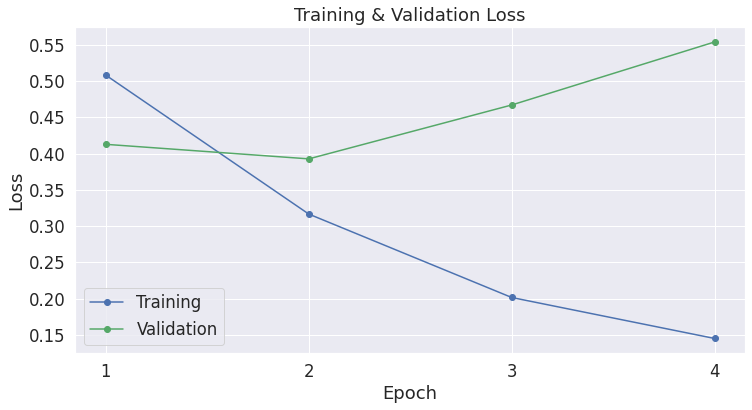

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##Saving & Loading Fine-Tuned Model

In [ ]:
import os
output_dir = "./model_save"

#create directory if not exist
if not os.path.exists(output_dir):
  os.makedirs(output_dir)
print(f"Saving model in directory  to {output_dir}")

model_to_save = model.module if hasattr(model,'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model in directory  to ./model_save


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
# Checking file size 
!ls -l --block-size=K ./model_save/

total 428000K
-rw-r--r-- 1 root root      1K Sep 15 04:32 config.json
-rw-r--r-- 1 root root 427754K Sep 15 04:32 pytorch_model.bin
-rw-r--r-- 1 root root      1K Sep 15 04:32 special_tokens_map.json
-rw-r--r-- 1 root root      1K Sep 15 04:32 tokenizer_config.json
-rw-r--r-- 1 root root    227K Sep 15 04:32 vocab.txt


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Sep 15 04:32 ./model_save/pytorch_model.bin


In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
# model.to(device)

##Performance On Test Set

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:


    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens =True,
                        max_length =64,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask =True,
                        return_tensors ='pt'
                   )
    

    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


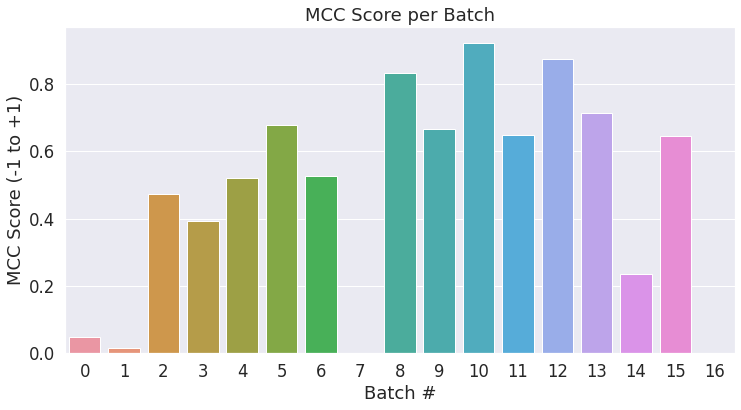

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.561


In [ ]:
!zip -r "cola_train_moddel.zip" '/content/model_save'

  adding: content/model_save/ (stored 0%)
  adding: content/model_save/tokenizer_config.json (deflated 39%)
  adding: content/model_save/pytorch_model.bin (deflated 7%)
  adding: content/model_save/special_tokens_map.json (deflated 40%)
  adding: content/model_save/config.json (deflated 49%)
  adding: content/model_save/vocab.txt (deflated 53%)


In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/cola_train_moddel.zip "/content/drive/MyDrive"